# Validación Cluster

## Tendencia del cluster

¿Habrá agrupación entre los datos?


In [1]:
library(purrr)

# Se elimina la columna que contiene la especie de planta
datos_iris <- iris[, -5]

# Se generan valores aleatorios dentro del rango de cada variable. Se utiliza la
# función map del paquete purrr.
datos_simulados <- map_df(datos_iris,
                          .f = function(x){runif(n = length(x),
                                                 min = min(x),
                                                 max = max(x))
                                          }
                          )

# Estandarización de los datos
datos_iris      <- scale(datos_iris)
datos_simulados <- scale(datos_simulados)

Una representación gráfica permite comprobar que el set de datos iris sí contiene grupos reales].

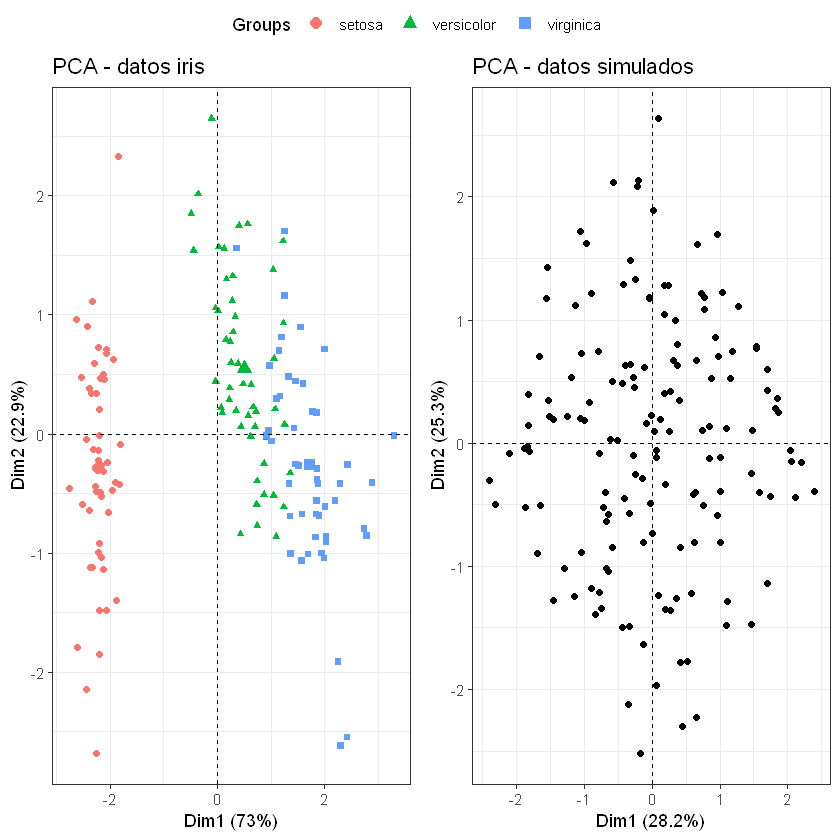

In [3]:
library(factoextra)
library(ggpubr)
pca_datos_iris      <- prcomp(datos_iris)
pca_datos_simulados <- prcomp(datos_simulados)
p1 <- fviz_pca_ind(X = pca_datos_iris, habillage = iris$Species,
                   geom = "point", title = "PCA - datos iris",
                   pallete = "jco") +
      theme_bw() + theme(legend.position = "bottom")
p2 <- fviz_pca_ind(X = pca_datos_simulados, geom = "point",
                   title = "PCA - datos simulados", pallete = "jco") +
      theme_bw() + theme(legend.position = "bottom")

ggarrange(p1, p2, common.legend = TRUE)

Al aplicar clusters:

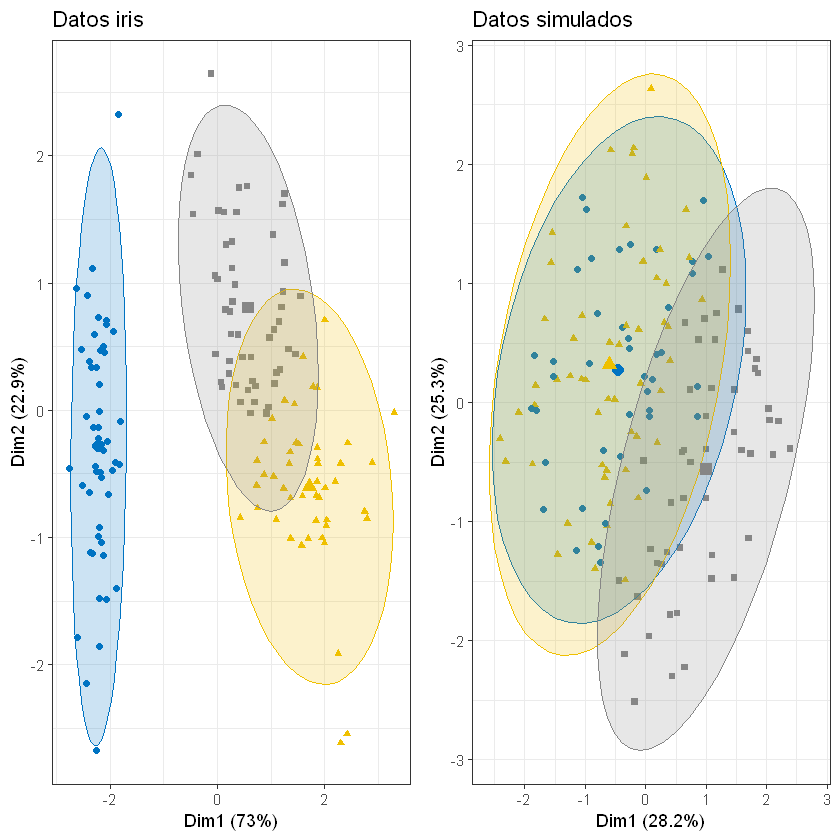

In [4]:
# K-means clustering
km_datos_iris <- kmeans(x = datos_iris, centers = 3)
p1 <- fviz_cluster(object = km_datos_iris, data = datos_iris,
                   ellipse.type = "norm", geom = "point", main = "Datos iris",
                   stand = FALSE, palette = "jco") +
      theme_bw() + theme(legend.position = "none")
km_datos_simulados <- kmeans(x = datos_simulados, centers = 3)
p2 <- fviz_cluster(object = km_datos_simulados, data = datos_simulados,
                   ellipse.type = "norm", geom = "point",
                   main = "Datos simulados", stand = FALSE, palette = "jco") +
      theme_bw() + theme(legend.position = "none")

# Hierarchical clustering
p3 <- fviz_dend(x = hclust(dist(datos_iris)), k = 3, k_colors = "jco",
                show_labels = FALSE, main = "Datos iris")
p4 <- fviz_dend(x = hclust(dist(datos_simulados)), k = 3, k_colors = "jco",
                show_labels = FALSE, main = "Datos simulados")

ggarrange(p1, p2)

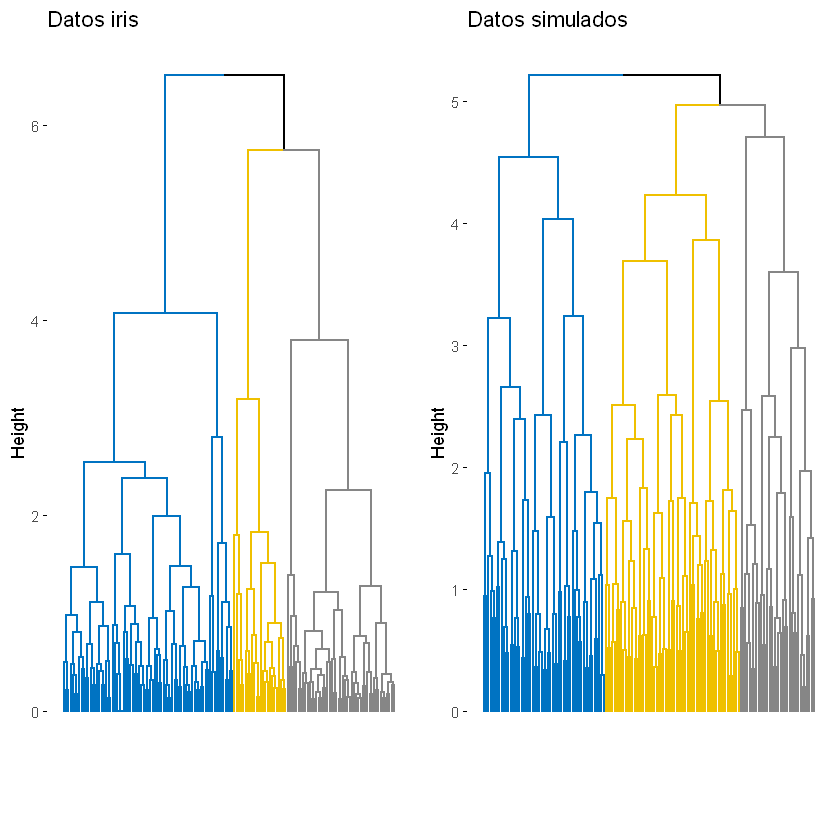

In [5]:
ggarrange(p3, p4)

## Estadístico de Hopkins


* Extraer una muestra de $n$ observaciones $(p_1,\dots ,p_n)$ del conjunto de datos.

* Para cada observación $p_i$ seleccionada, encontrar la observación vecina más cercana $p_j$ y calcular la distancia entre ambas, $x_i=dist(pi,pj)$.

* Simular un conjunto de datos de tamaño $n$: $(q_1,\dots, q_n)$ extraídos de una distribución uniforme con la misma variación que los datos originales.

* Para cada observación simulada $q_i$, encontrar la observación vecina más cercana $q_j$ y calcular la distancia entre ambas, $y_i=dist(q_i,q_j)$.

* Calcular el estadístico Hopkins $(H)$ como la media de las distancias de vecinos más cercanos en el set de datos simulados, dividida por la suma de las medias de las distancias vecinas más cercanas del set de datos original y el simulado.

$$ H = \frac{\sum^n_{i=1}y_i}{\sum^n_{i=1}x_i + \sum^n_{i=1}y_i}$$

Valores de $H$ en torno a 0.5 indican que $\sum^n_{i=1}x_i$ y $\sum^n_{i=1}y_i$ son muy cercanos el uno al otro.


In [10]:
install.packages("clustertend")

Installing package into 'C:/Users/cizai/OneDrive/Documentos/R/win-library/3.6'
(as 'lib' is unspecified)



package 'clustertend' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cizai\AppData\Local\Temp\RtmpwzC6Xx\downloaded_packages


In [15]:
library(clustertend)
set.seed(321)

# Estadístico H para el set de datos iris
hopkins(data = datos_iris, n = nrow(datos_iris) - 1)

$H
[1] 0.1842089

In [16]:
hopkins(data = datos_simulados, n = nrow(datos_simulados) - 1)

$H
[1] 0.5113027

## Tendencia visual de cluster

VAT es un método visual que permite identificar la tendencia de cluster.

* Se calcula una matriz de distancias euclídeas entre todos los pares de observaciones.

* Se reordena la matriz de distancias de forma que las observaciones similares están situadas cerca unas de otras (ordered dissimilarity matrix).

* Se representa gráficamente la matriz de distancias ordenada, empleando un gradiente de color para el valor de las distancias. Si existen agrupaciones subyacentes en los datos se forma un patrón de bloques cuadrados.



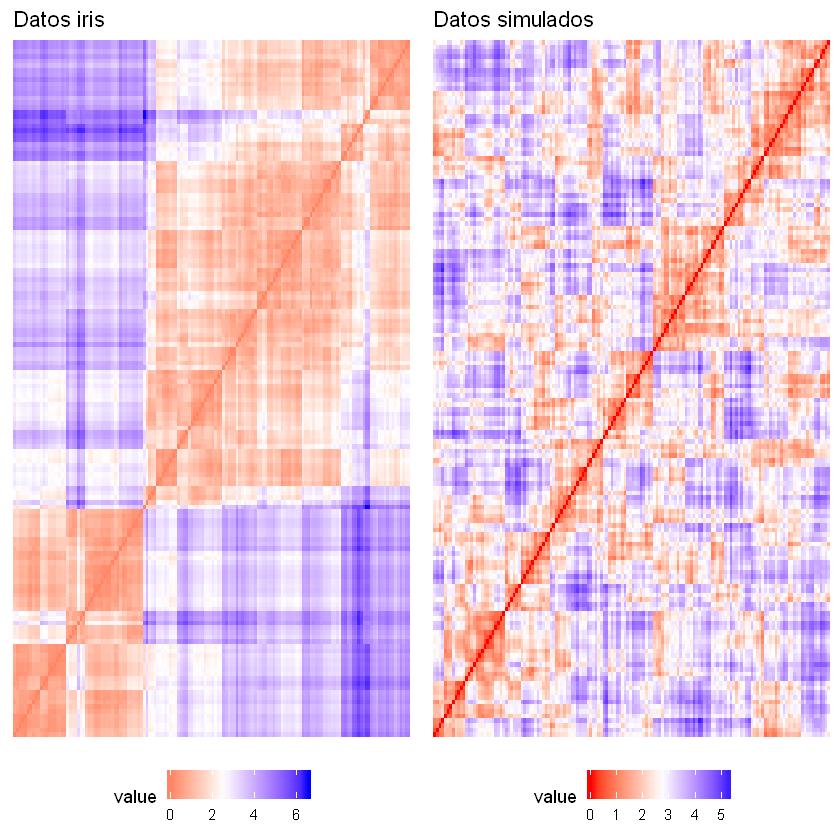

In [17]:
library(factoextra)
library(ggpubr)
dist_datos_iris      <- dist(datos_iris, method = "euclidean")
dist_datos_simulados <- dist(datos_simulados, method = "euclidean")

p1 <- fviz_dist(dist.obj = dist_datos_iris, show_labels = FALSE) +
      labs(title = "Datos iris") + theme(legend.position = "bottom")
p2 <- fviz_dist(dist.obj = dist_datos_simulados, show_labels = FALSE) +
      labs(title = "Datos simulados") + theme(legend.position = "bottom")

ggarrange(p1, p2)

## Número de clusters

No hay una fórmula única que nos permita determinar una cantidad de apropiada de clusters. Depende fuertemente del problema estudiado, sin embargo, hay algunas herramientas que nos pueden ayudar. 

### Método Elbow

El método Elbow calcula la varianza total intra-cluster en función del número de clusters y escoge como óptimo aquel valor a partir del cual añadir más clusters apenas consigue mejoría.

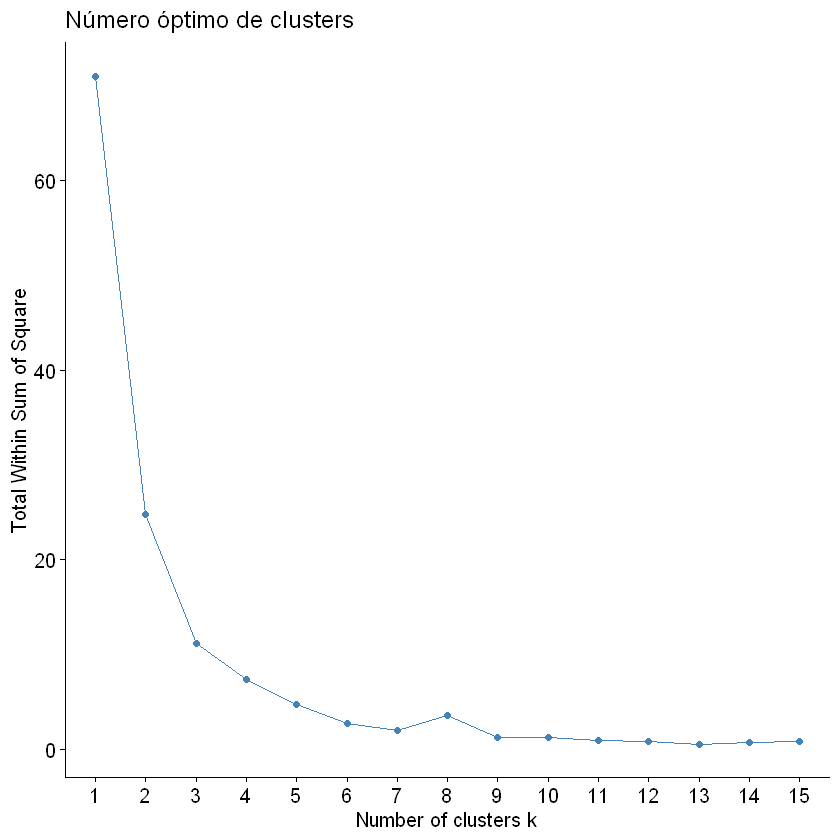

In [20]:
library(factoextra)
datos <- scale(USAccDeaths)
fviz_nbclust(x = datos, FUNcluster = kmeans, method = "wss", k.max = 15) +
  labs(title = "Número óptimo de clusters")

In [21]:
calcular_totwithinss <- function(n_clusters, datos, iter.max=1000, nstart=50){
  # Esta función aplica el algoritmo kmeans y devuelve la suma total de
  # cuadrados internos.
  cluster_kmeans <- kmeans(centers = n_clusters, x = datos, iter.max = iter.max,
                           nstart = nstart)
  return(cluster_kmeans$tot.withinss)
}

# Se aplica esta función con para diferentes valores de k
total_withinss <- map_dbl(.x = 1:15,
                          .f = calcular_totwithinss,
                          datos = datos)
total_withinss

[1] 71.0000000 24.7746285 11.2240436  7.4305560  4.3289310  2.7453934
 [7]  1.9551950  1.4706169  1.1052515  0.8627109  0.7799124  0.5050164
[13]  0.4470955  0.3582247  0.2849938

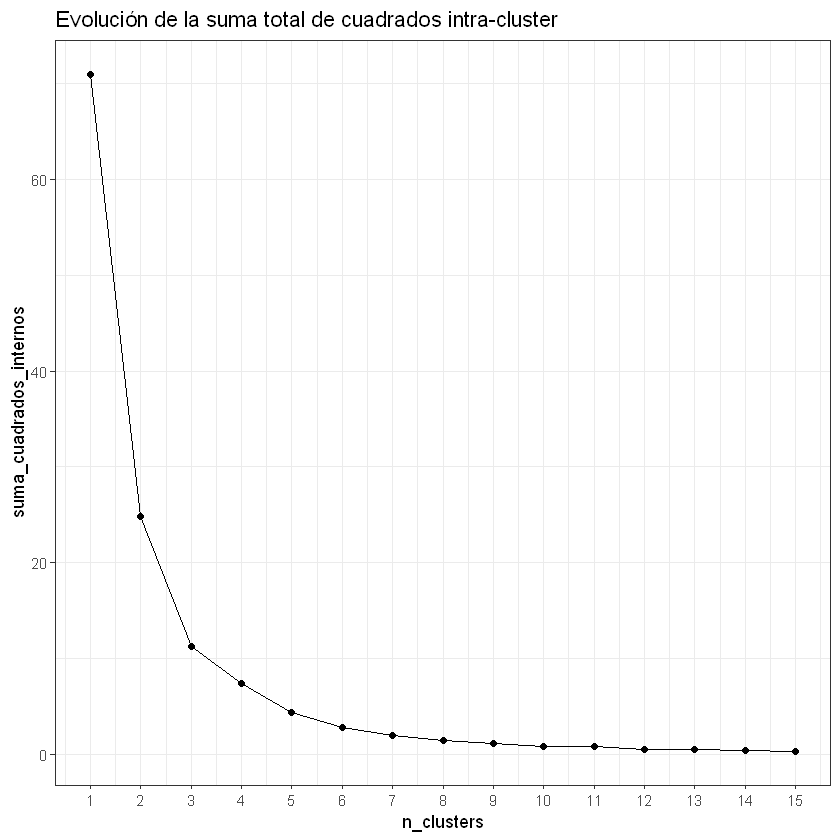

In [22]:
data.frame(n_clusters = 1:15, suma_cuadrados_internos = total_withinss) %>%
  ggplot(aes(x = n_clusters, y = suma_cuadrados_internos)) +
    geom_line() +
    geom_point() +
    scale_x_continuous(breaks = 1:15) +
    labs(title = "Evolución de la suma total de cuadrados intra-cluster") +
    theme_bw()

### Método Silueta Media

Se usa el coeficiente de silueta, un valor que mide que tan buena es la asignación a una observación, comparando su similitud con el resto de observaciones de su cluster. Se calcula de la siguiente manera:

* Se calcula el promedio de las distancias entre la observación $j$ y el resto de observaciones que pertenecen al mismo cluster, lo denominamos $a_j$.¿Que esperamos?

* Calcular la distancia promedio entre la observación $j$ y el resto de clusters. Para esto se determina la media de las distancias de $j$ con todos los elementos del cluster estudiado.

* Identificar como $b_j$ a la menor de las distancias promedio entre $j$ y el resto de clusters, es decir, la distancia al cluster más próximo.

* Calcular el valor de silhouette como:

$$ s_j = \frac{b_j - a_j}{max(a_j, b_j)}$$




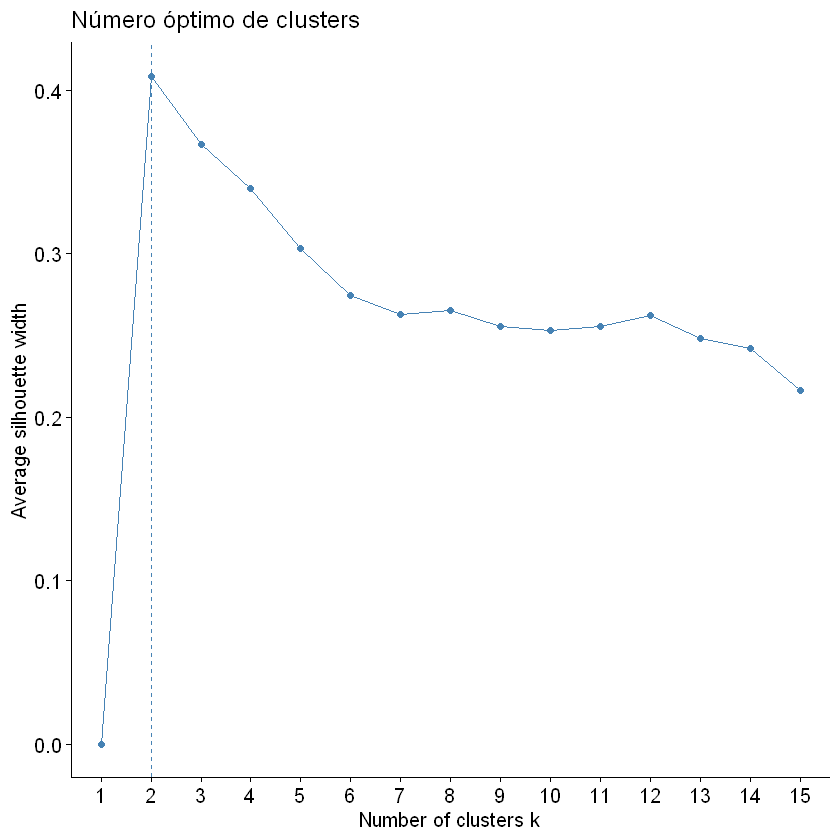

In [25]:
library(factoextra)
datos <- scale(USArrests)
fviz_nbclust(x = datos, FUNcluster = kmeans, method = "silhouette", k.max = 15) +
  labs(title = "Número óptimo de clusters")

###  Estadísitico GAP 

Consiste en lo siguiente:

* Hacer clustering de los datos para un rango de valores de $k$, para cada uno, calcular el valor de la varianza total intra-cluster $(Wk)$.

* Simular B conjuntos de datos, todos ellos con una distribución aleatoria uniforme. Aplicar clustering a cada uno de los sets con el mismo rango de valores $k$, determinar $(Wkb)$ para cada simulación. B debe ser 500.

* El estadístico GAP se calcula de la siguiente forma:

$$gap(k) = \frac{1}{B} \sum^B_{b=1}log(W_{kb})-log(W_k)$$

* Calcular las desviaciones estandar $s_k$.

* Identificar el número de clusters óptimo como el menor de los valores $k$ para el que el estadístico gap se aleja menos de una desviación estándar del valor gap del siguiente $k$: $$gap(k)≥gap(k+1)−sk+1.$$

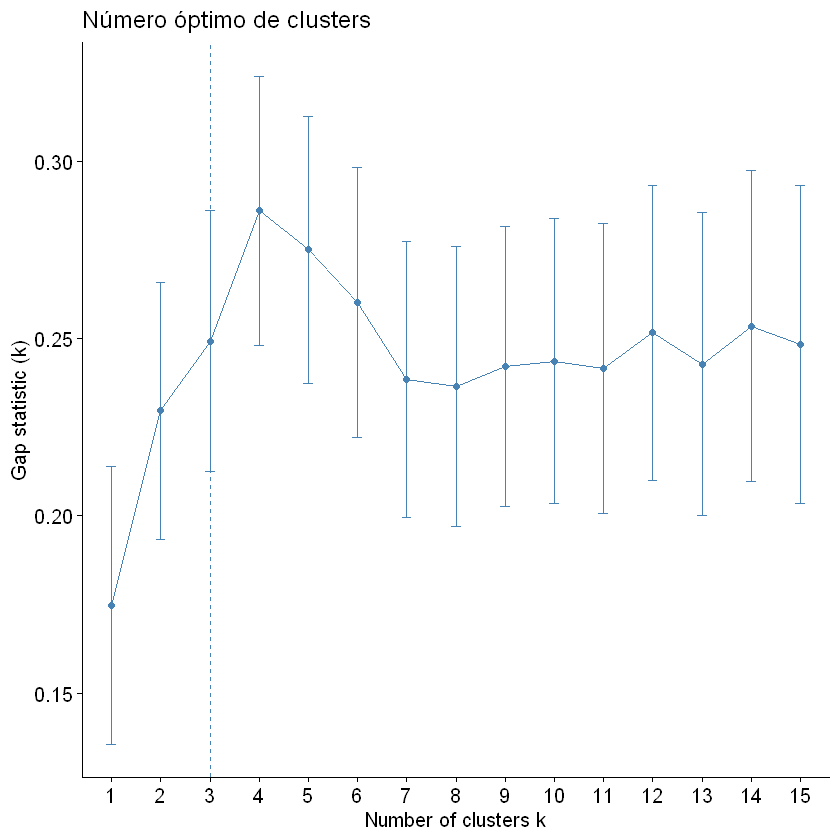

In [26]:
library(factoextra)
datos <- scale(USArrests)
set.seed(896)
fviz_nbclust(x = datos, FUNcluster = kmeans, method = "gap_stat", nboot = 500,
             k.max = 15, verbose = FALSE, nstart = 50) +
  labs(title = "Número óptimo de clusters")

## Calidad de los cluster

### Validación interna de los clusters

**Ancho de silueta**

Cuantifica cómo de buena es la asignación que se ha hecho de una observación comparando su similitud con el resto de observaciones del mismo cluster frente a las de los otros clusters. Para cada observación $j$, el silhouette coeficient $(s_j)$ se obtiene del siguiente modo:

Calculamos:

$$s_i = \frac{b_j - a_j}{max(a_j, b_j)}$$

Su valor puede estar entre -1 y 1, siendo valores altos un indicativo de que la observación se ha asignado al cluster correcto. Cuando su valor es próximo a cero significa que la observación se encuentra en un punto intermedio entre dos clusters. Valores negativos apuntan a una posible asignación incorrecta de la observación. Se trata por lo tanto de un método que permite evaluar el resultado del clustering a múltiples niveles:

* La calidad de asignación de cada observación por separado. Permitiendo identificar potenciales asignaciones erróneas.

* La calidad de cada cluster a partir del promedio de los índices silhouette de todas las observaciones que lo forman. Si por ejemplo se han introducido demasiados clusters, es muy probable que algunos de ellos tengan un valor promedio mucho menor que el resto.

* La calidad de la estructura de clusters en su conjunto a partir del promedio de todos los índices silhouette.


  cluster size ave.sil.width
1       1   50          0.64
2       2   53          0.39
3       3   47          0.35


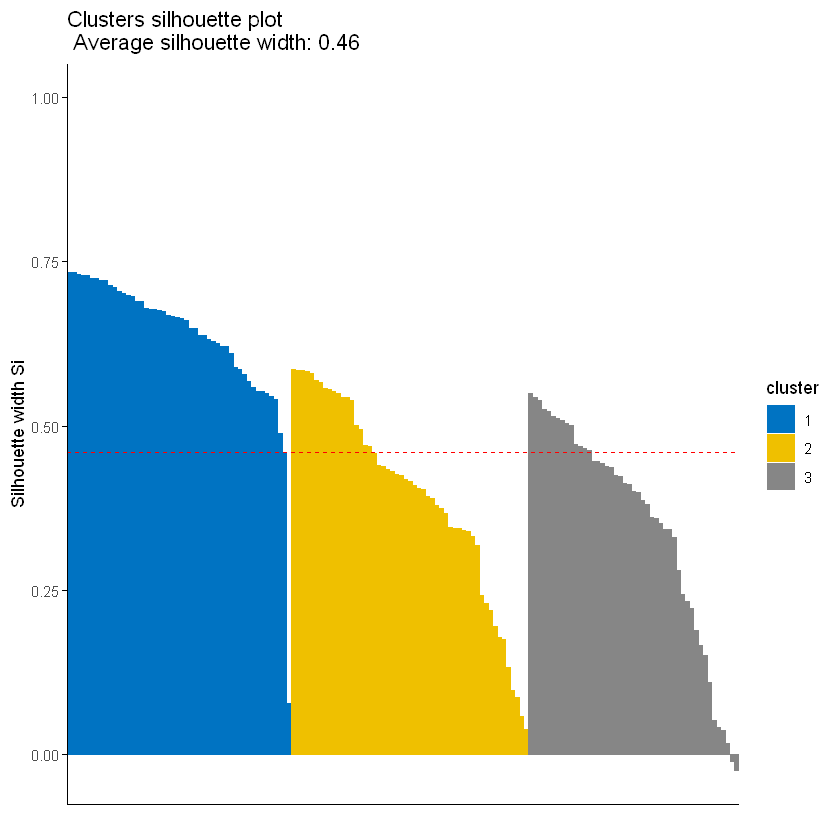

In [27]:
library(factoextra)
# Se emplean los datos iris excluyendo la variable Species
datos <- scale(iris[, -5])
km_clusters <- eclust(x = datos, FUNcluster = "kmeans", k = 3, seed = 123,
                      hc_metric = "euclidean", nstart = 50, graph = FALSE)
fviz_silhouette(sil.obj = km_clusters, print.summary = TRUE, palette = "jco",
                ggtheme = theme_classic()) 

In [28]:
# Media silhouette por cluster
km_clusters$silinfo$clus.avg.widths

[1] 0.6363162 0.3933772 0.3473922

In [29]:
# Coeficiente silhouette para cada observación
head(km_clusters$silinfo$widths)

,cluster,neighbor,sil_width
,<fct>,<dbl>,<dbl>
1,1,2,0.7341949
41,1,2,0.7333345
8,1,2,0.7308169
18,1,2,0.7287522
5,1,2,0.7284741
40,1,2,0.7247047


### Indice Duhn

El índice Dunn es otra medida de validación interna que se obtiene de la siguiente forma:

* Para cada cluster calcular la distancia entre cada una de las observaciones que lo forman y las observaciones de los otros clusters.

* Seleccionar como “representante” de la distancia entre clusters a la menor de todas las distancias calculadas en el paso anterior (separación mínima inter-clusters).

* Para cada cluster calcular la distancia entre las observaciones que lo forman (intra-cluster distance).

* Seleccionar como “representante” de la distancia intra-cluster a la mayor de todas las distancias calculadas en el paso anterior (separación máxima intra-cluster).

Calcular el índice Dunn como:

$$D = \frac{separacion \ minima \ interclusters}{separacion \ maxima \ intracluster}$$

Si la estructura contiene clusters compactos y bien separados, el numerador es grande y el denominador pequeño, dando lugar a valores altos de D. El objetivo por lo tanto es maximizar el índice Dunn. Esta forma de evaluar la calidad del clustering tiene un inconveniente. Si todos los clusters tienen un comportamiento ideal excepto uno, cuya calidad es baja, dado que el denominador emplea el máximo en lugar de la media, el índice estará totalmente influenciado por este cluster enmascarando al resto. Es importante tener en cuenta que se trata de un indicador de tipo “el peor de los casos”.

In [31]:
install.packages("fpc")

Installing package into 'C:/Users/cizai/OneDrive/Documentos/R/win-library/3.6'
(as 'lib' is unspecified)

also installing the dependencies 'modeltools', 'DEoptimR', 'mclust', 'flexmix', 'prabclus', 'diptest', 'robustbase', 'kernlab'





  There is a binary version available but the source version is later:
       binary source needs_compilation
mclust  5.4.5  5.4.6              TRUE

  Binaries will be installed
package 'modeltools' successfully unpacked and MD5 sums checked
package 'DEoptimR' successfully unpacked and MD5 sums checked
package 'mclust' successfully unpacked and MD5 sums checked
package 'flexmix' successfully unpacked and MD5 sums checked
package 'prabclus' successfully unpacked and MD5 sums checked
package 'diptest' successfully unpacked and MD5 sums checked
package 'robustbase' successfully unpacked and MD5 sums checked
package 'kernlab' successfully unpacked and MD5 sums checked
package 'fpc' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cizai\AppData\Local\Temp\RtmpwzC6Xx\downloaded_packages


In [32]:
library(fpc)
# Se emplean los datos iris excluyendo la variable Species
datos <- scale(iris[, -5])

# K-means clustering con k = 3
set.seed(321)
km_clusters <- kmeans(x = dist(datos, method = "euclidean"), centers = 3,
                      nstart = 50)
# Cálculo de índices (se calculan un total de 34 índices y parámetros)
km_indices <- cluster.stats(d = dist(datos, method = "euclidean"), 
                            clustering = km_clusters$cluster)

# Medidas de homogeneidad y separación
km_indices$average.within

Warning message:
"package 'fpc' was built under R version 3.6.3"


[1] 1.238354